# Import Library

In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Import Dataset

In [24]:
# Load the dataset
df = pd.read_csv('dataset/ai_ghibli_trend_dataset_v2.csv')
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
df.head()

Dataset shape: (500, 16)

First 5 rows:


image_id   user_id  \
0  77ce5c72-eb45-4651-bcb1-c0677c0fceaf  6a7adf3d   
1  7d66c67f-0d11-4ef9-895c-d865ef11fe40  523b8706   
2  d7978afd-3932-4cce-9a21-5f9bf2bc1f64  0e02592a   
3  cb34636a-a15c-4b15-999c-759dbb8896fe  9ed78a42   
4  7511fbb8-db05-4584-a3a4-e8bb525ed58b  69ec8f02   

                                         prompt  likes  shares  comments  \
0  Studio Ghibli-inspired ocean with giant fish    916     410       555   
1                Ghibli-style village at sunset   2965    1361       417   
2   A lone traveler exploring an enchanted ruin   4727     655       785   
3    Spirited Away-style bustling market street   1629    1954       212   
4  Magical Ghibli forest with floating lanterns   2573    1281       913   

    platform  generation_time  gpu_usage  file_size_kb resolution  \
0     Reddit             4.80         49          1684  1024x1024   
1     Reddit            11.11         81          2808  1024x1024   
2  Instagram             5.56         41          1800  2048x2048   
3     TikTok            12.45         88           479  2048x2048   
4     TikTok             4.80         64          1789    512x512   

   style_accuracy_score is_hand_edited ethical_concerns_flag creation_date  \
0                    89            Yes                   Yes    2025-03-11   
1                    92            Yes                    No    2025-03-11   
2                    61             No                    No    2025-03-06   
3                    76             No                    No    2025-03-23   
4                    58             No                   Yes    2025-03-06   

                                         top_comment  
0  So nostalgic, feels like childhood memories. 🎥...  
1     Absolutely stunning! Love the details. 🎨 #5729  
2      Is this AI or hand-painted? Incredible! #8001  
3      Is this AI or hand-painted? Incredible! #5620  
4  This looks straight out of a Ghibli movie! 🌟 #...

# Data Preprocessing and Feature Engineering

In [25]:
# Feature Engineering
print("="*60)
print("FEATURE ENGINEERING")
print("="*60)

# Split resolution into width and height
df[['width', 'height']] = df['resolution'].str.split('x', expand=True).astype(int)

# Convert categorical binary features to numeric
df['is_hand_edited'] = (df['is_hand_edited'] == 'Yes').astype(int)
df['ethical_concerns_flag'] = (df['ethical_concerns_flag'] == 'Yes').astype(int)

# Extract temporal features
df['creation_date'] = pd.to_datetime(df['creation_date'])
df['day_of_week'] = df['creation_date'].dt.dayofweek
df['month'] = df['creation_date'].dt.month
df['hour'] = df['creation_date'].dt.hour

# Create derived features
df['aspect_ratio'] = df['width'] / df['height']
df['total_pixels'] = df['width'] * df['height']
df['is_square'] = (df['width'] == df['height']).astype(int)
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

print(f"Features created successfully!")
print(f"Total features: {df.shape[1]}")

FEATURE ENGINEERING
Features created successfully!
Total features: 25


# Target Variable Analysis

TARGET VARIABLE ANALYSIS

Shares Statistics:
Mean: 1040.18
Median: 1092.00
Std Dev: 562.67
Min: 13
Max: 1999
Skewness: -0.14


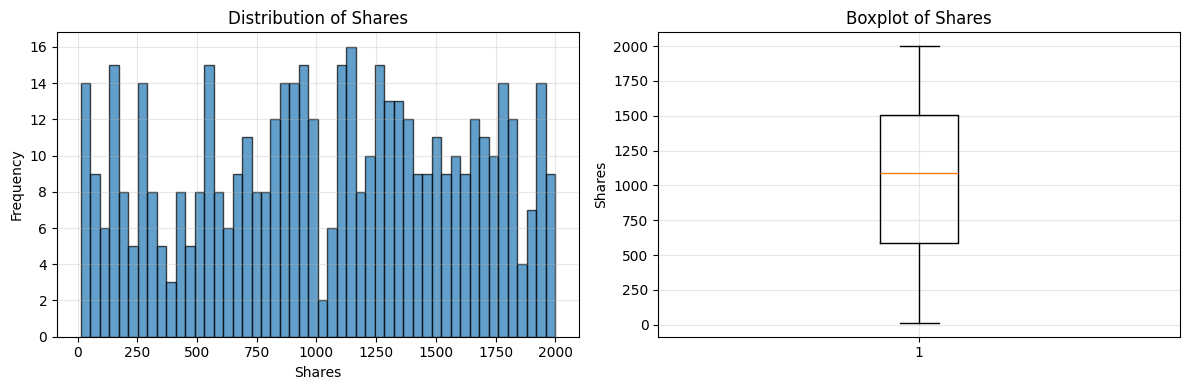

In [26]:
# Analyze the target variable
print("="*60)
print("TARGET VARIABLE ANALYSIS")
print("="*60)

# Define target and features
y = df['shares']
X = df.drop(columns=['image_id', 'user_id', 'prompt', 'shares', 'comments',
                     'top_comment', 'resolution', 'creation_date'])

# One-hot encode platform
X = pd.get_dummies(X, columns=['platform'], prefix='platform')

# Target statistics
print(f"\nShares Statistics:")
print(f"Mean: {y.mean():.2f}")
print(f"Median: {y.median():.2f}")
print(f"Std Dev: {y.std():.2f}")
print(f"Min: {y.min()}")
print(f"Max: {y.max()}")
print(f"Skewness: {y.skew():.2f}")

# Visualize target distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(y, bins=50, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Shares')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Shares')
ax1.grid(True, alpha=0.3)

ax2.boxplot(y, vert=True)
ax2.set_ylabel('Shares')
ax2.set_title('Boxplot of Shares')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature Analysis and Selection

FEATURE CORRELATION ANALYSIS
Top 15 Feature Correlations with Shares:
                  feature  correlation
19       platform_Twitter    -0.113105
16     platform_Instagram     0.070970
13           total_pixels     0.053401
7                   width     0.050954
8                  height     0.050954
17        platform_Reddit     0.030825
0                   likes    -0.029318
5          is_hand_edited     0.028240
9             day_of_week     0.024903
3            file_size_kb    -0.020748
6   ethical_concerns_flag     0.019647
18        platform_TikTok     0.016843
2               gpu_usage     0.015755
15             is_weekend     0.015367
4    style_accuracy_score     0.011279


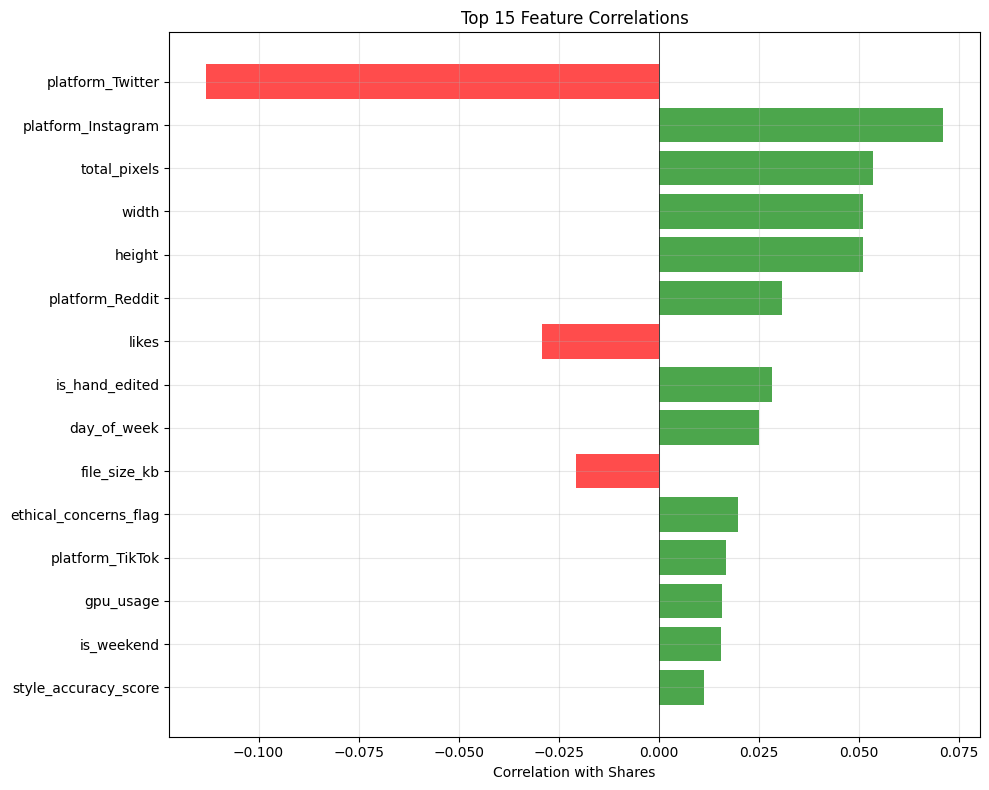

In [27]:
# Feature correlation analysis
print("="*60)
print("FEATURE CORRELATION ANALYSIS")
print("="*60)

# Calculate correlations with target
correlations = pd.DataFrame({
    'feature': X.columns,
    'correlation': [X[col].corr(y) for col in X.columns]
}).sort_values('correlation', key=abs, ascending=False)

print("Top 15 Feature Correlations with Shares:")
print(correlations.head(15))

# Visualization of correlations
plt.figure(figsize=(10, 8))
top_features = correlations.head(15)
colors = ['green' if x > 0 else 'red' for x in top_features['correlation']]
plt.barh(range(len(top_features)), top_features['correlation'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Correlation with Shares')
plt.title('Top 15 Feature Correlations')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Advanced Feature Engineering

In [28]:
# Create interaction and polynomial features
print("="*60)
print("CREATING ADVANCED FEATURES")
print("="*60)

# Log transform target (to handle skewness)
y_log = np.log1p(y)  # log1p handles zeros safely

# Create interaction features
X['engagement_rate'] = X['likes'] / (X['total_pixels'] / 1000000 + 1)
X['quality_engagement'] = X['style_accuracy_score'] * X['likes'] / 100
X['file_density'] = X['file_size_kb'] / (X['total_pixels'] / 1000 + 1)
X['gpu_efficiency'] = X['generation_time'] / (X['gpu_usage'] + 1)

# Platform-specific features
for platform in ['Twitter', 'TikTok', 'Reddit']:
    if f'platform_{platform}' in X.columns:
        X[f'{platform.lower()}_likes'] = X['likes'] * X[f'platform_{platform}']

# Temporal cyclical features
X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
X['day_sin'] = np.sin(2 * np.pi * X['day_of_week'] / 7)
X['day_cos'] = np.cos(2 * np.pi * X['day_of_week'] / 7)

print(f"Total features after engineering: {X.shape[1]}")

# Remove highly correlated features
corr_matrix = X.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
X = X.drop(columns=to_drop)
print(f"Features after removing multicollinearity: {X.shape[1]}")

CREATING ADVANCED FEATURES
Total features after engineering: 31
Features after removing multicollinearity: 29


# Train-Test Split and Scaling

In [29]:
# Split the data
print("="*60)
print("DATA SPLITTING AND SCALING")
print("="*60)

# Use both original and log-transformed targets
X_train, X_test, y_train, y_test, y_log_train, y_log_test = train_test_split(
    X, y, y_log, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed!")

DATA SPLITTING AND SCALING
Training set: (400, 29)
Test set: (100, 29)
Data preprocessing completed!


# Training Multiple Regression Models

In [30]:
# Train multiple regression models
print("="*60)
print("TRAINING REGRESSION MODELS")
print("="*60)

# Dictionary to store results
results = {}

# Model 1: Linear Regression
print("\n1. Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
results['Linear Regression'] = {
    'predictions': y_pred_lr,
    'r2': r2_score(y_test, y_pred_lr),
    'mae': mean_absolute_error(y_test, y_pred_lr),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_lr))
}

# Model 2: Ridge Regression
print("2. Ridge Regression...")
ridge = Ridge(alpha=10.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)
results['Ridge Regression'] = {
    'predictions': y_pred_ridge,
    'r2': r2_score(y_test, y_pred_ridge),
    'mae': mean_absolute_error(y_test, y_pred_ridge),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_ridge))
}

# Model 3: Lasso Regression
print("3. Lasso Regression...")
lasso = Lasso(alpha=1.0)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)
results['Lasso Regression'] = {
    'predictions': y_pred_lasso,
    'r2': r2_score(y_test, y_pred_lasso),
    'mae': mean_absolute_error(y_test, y_pred_lasso),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_lasso))
}

# Model 4: Random Forest
print("4. Random Forest Regressor...")
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
results['Random Forest'] = {
    'predictions': y_pred_rf,
    'r2': r2_score(y_test, y_pred_rf),
    'mae': mean_absolute_error(y_test, y_pred_rf),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_rf))
}

# Model 5: Gradient Boosting
print("5. Gradient Boosting Regressor...")
gb = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)
results['Gradient Boosting'] = {
    'predictions': y_pred_gb,
    'r2': r2_score(y_test, y_pred_gb),
    'mae': mean_absolute_error(y_test, y_pred_gb),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_gb))
}

print("\nAll models trained successfully!")

TRAINING REGRESSION MODELS

1. Linear Regression...
2. Ridge Regression...
3. Lasso Regression...
4. Random Forest Regressor...
5. Gradient Boosting Regressor...

All models trained successfully!


# Model Comparison Table

In [31]:
# Create comparison table
print("="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': results.keys(),
    'R² Score': [results[m]['r2'] for m in results],
    'MAE': [results[m]['mae'] for m in results],
    'RMSE': [results[m]['rmse'] for m in results]
})

comparison_df = comparison_df.sort_values('R² Score', ascending=False)
print("\nRegression Models Performance:")
print(comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\nBest performing model: {best_model_name}")

MODEL PERFORMANCE COMPARISON

Regression Models Performance:
            Model  R² Score        MAE       RMSE
    Random Forest -0.085036 518.768500 593.750611
 Ridge Regression -0.086767 528.589291 594.223994
 Lasso Regression -0.087646 528.573249 594.464161
Linear Regression -0.099142 531.413278 597.597560
Gradient Boosting -0.235788 537.630957 633.656677

Best performing model: Random Forest


# Visualization of Results

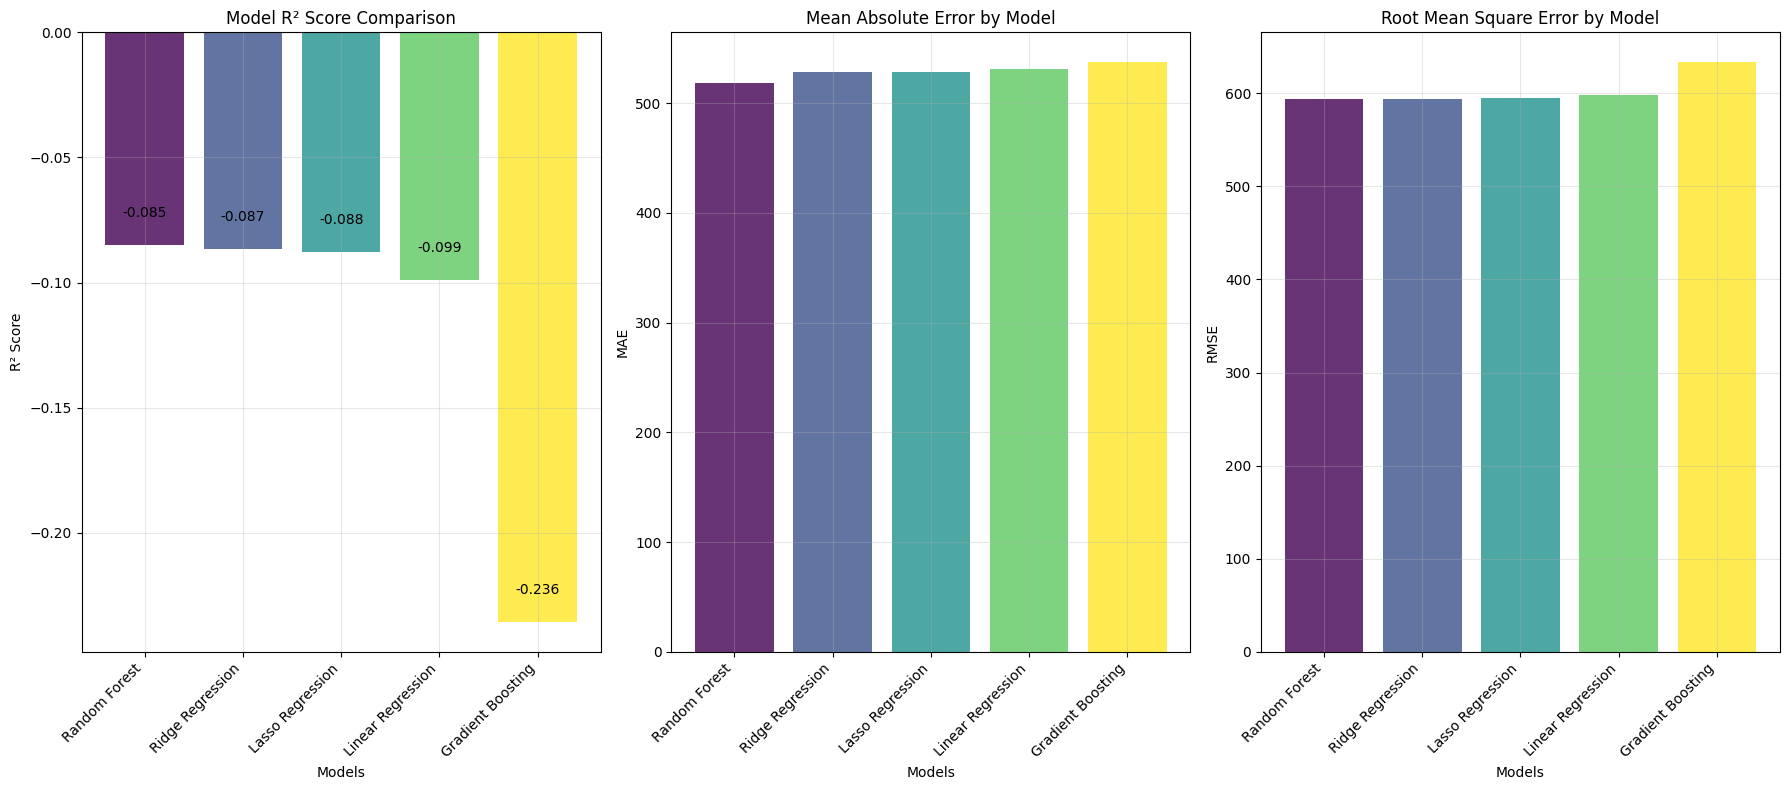

In [32]:
# Comprehensive visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# 1. Model Performance Comparison
ax = axes[0]
x_pos = np.arange(len(comparison_df))
colors = plt.cm.viridis(np.linspace(0, 1, len(comparison_df)))
bars = ax.bar(x_pos, comparison_df['R² Score'], color=colors, alpha=0.8)
ax.set_xlabel('Models')
ax.set_ylabel('R² Score')
ax.set_title('Model R² Score Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Add value labels
for bar, value in zip(bars, comparison_df['R² Score']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{value:.3f}', ha='center', va='bottom')

# 2. MAE Comparison
ax = axes[1]
bars = ax.bar(x_pos, comparison_df['MAE'], color=colors, alpha=0.8)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.set_title('Mean Absolute Error by Model')
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.grid(True, alpha=0.3)

# 3. RMSE Comparison (continued)
ax = axes[2]
bars = ax.bar(x_pos, comparison_df['RMSE'], color=colors, alpha=0.8)
ax.set_xlabel('Models')
ax.set_ylabel('RMSE')
ax.set_title('Root Mean Square Error by Model')
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Best Model: Random Forest

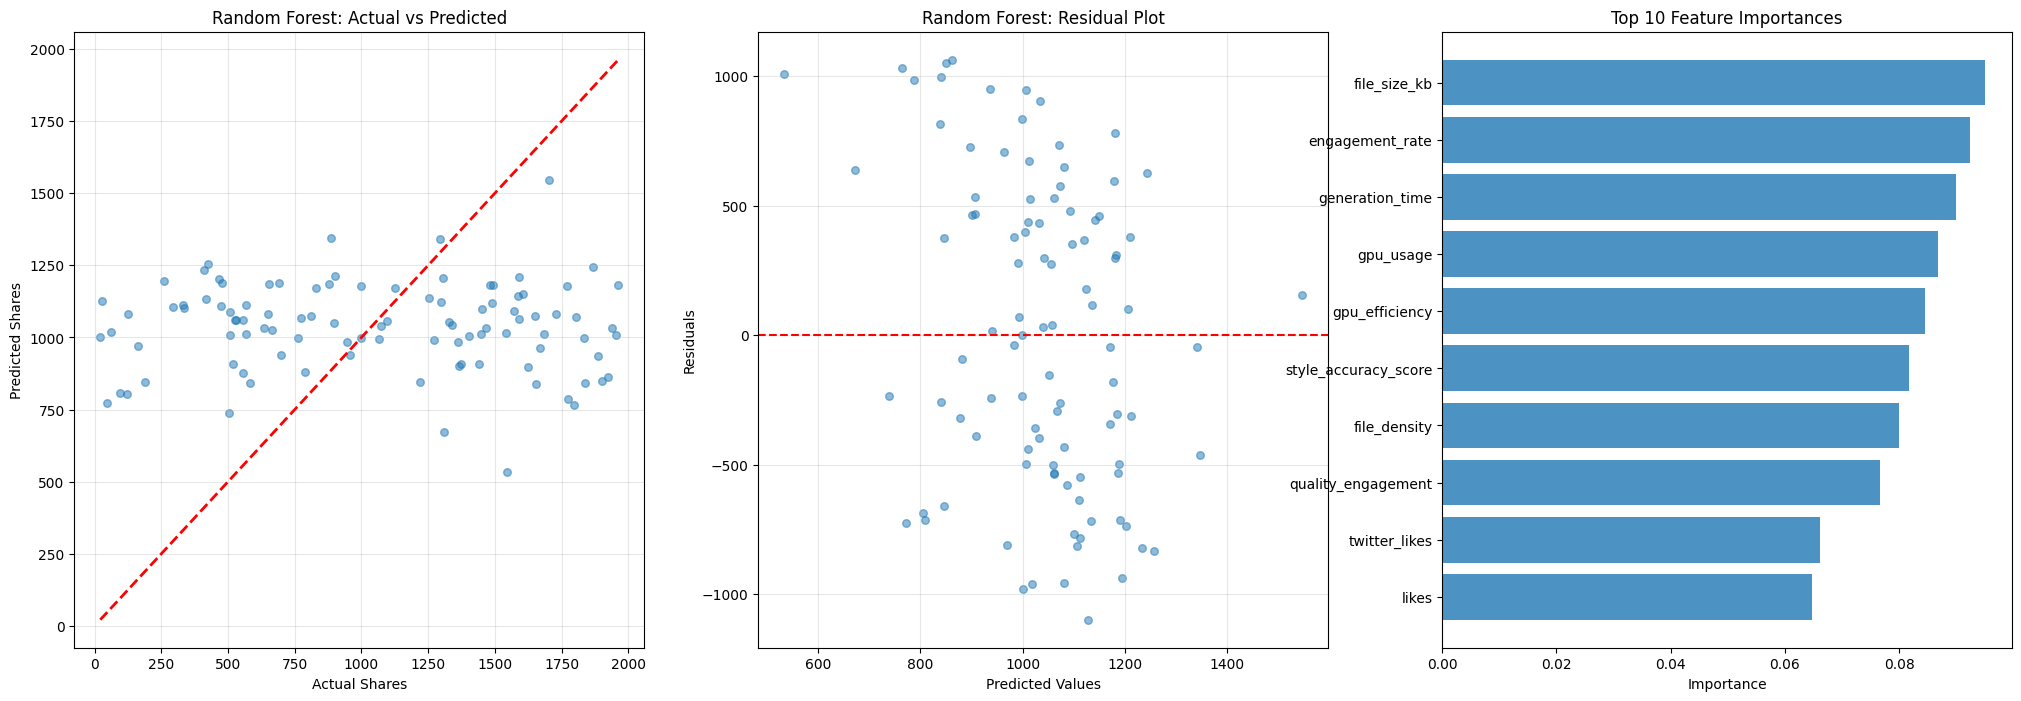

In [33]:
# Comprehensive visualization
fig, axes = plt.subplots(1, 3, figsize=(25, 8))

# 4. Best Model: Actual vs Predicted
ax = axes[0]
best_predictions = results[best_model_name]['predictions']
ax.scatter(y_test, best_predictions, alpha=0.5, s=30)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax.set_xlabel('Actual Shares')
ax.set_ylabel('Predicted Shares')
ax.set_title(f'{best_model_name}: Actual vs Predicted')
ax.grid(True, alpha=0.3)

# 5. Residual Plot for Best Model
ax = axes[1]
residuals = y_test - best_predictions
ax.scatter(best_predictions, residuals, alpha=0.5, s=30)
ax.axhline(y=0, color='red', linestyle='--')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title(f'{best_model_name}: Residual Plot')
ax.grid(True, alpha=0.3)

# 6. Feature Importance (for tree-based models)
ax = axes[2]
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    model = rf if best_model_name == 'Random Forest' else gb
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)

    y_pos = np.arange(len(feature_importance))
    ax.barh(y_pos, feature_importance['importance'], alpha=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feature_importance['feature'])
    ax.set_xlabel('Importance')
    ax.set_title('Top 10 Feature Importances')
    ax.invert_yaxis()
else:
    # For linear models, show coefficients
    model = lr if best_model_name == 'Linear Regression' else (ridge if best_model_name == 'Ridge Regression' else lasso)
    coef_df = pd.DataFrame({
        'feature': X.columns,
        'coefficient': model.coef_
    }).sort_values('coefficient', key=abs, ascending=False).head(10)

    y_pos = np.arange(len(coef_df))
    colors_coef = ['green' if x > 0 else 'red' for x in coef_df['coefficient']]
    ax.barh(y_pos, coef_df['coefficient'], color=colors_coef, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(coef_df['feature'])
    ax.set_xlabel('Coefficient Value')
    ax.set_title('Top 10 Coefficients by Magnitude')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.invert_yaxis()

# Final Model Insights

POSSIBLE REASONS FOR MODEL PERFORMANCE:
1. Low feature correlations suggest missing important predictors
2. The relationship between features and shares may be highly non-linear
3. External factors not captured in the dataset may drive virality
4. Possible data quality issues or synthetic data patterns

RECOMMENDATIONS FOR IMPROVEMENT:
1. Collect additional features (user follower count, posting time, hashtags)
2. Try more advanced models (XGBoost, Neural Networks)
3. Feature engineering focusing on user engagement patterns
4. Consider time-series aspects of virality
5. Investigate outliers and data quality issues

# Save Models

In [35]:
import joblib

# Save all models and the scaler
models_to_save = {
    'linear_regression': lr,
    'ridge_regression': ridge,
    'lasso_regression': lasso,
    'random_forest': rf,
    'gradient_boosting': gb
}

# Save each model
for model_name, model in models_to_save.items():
    joblib.dump(model, f'models/{model_name}.joblib')

# Save the scaler
joblib.dump(scaler, 'models/scaler.joblib')

print("All models and scaler have been saved successfully!")

All models and scaler have been saved successfully!


# Prediction Function

In [36]:
# Dictionary to hold the loaded model objects
all_models = {}
model_names = [
    'Linear Regression', 'Ridge Regression', 'Lasso Regression',
    'Random Forest', 'Gradient Boosting'
]

try:
    # Load all the regression models
    for name in model_names:
        filename = f"models/{name.lower().replace(' ', '_')}.joblib"
        all_models[name] = joblib.load(filename)
        print(f"Loaded: {name}")

    # Load the scaler ONCE, after the loop
    scaler = joblib.load('models/scaler.joblib')
    print("Loaded: scaler.joblib")

    models_loaded = True
    print("\n✅ All models and scaler loaded successfully!")

    # Get the feature names the model was trained on from the scaler
    expected_columns = scaler.feature_names_in_
    print(f"Model expects {len(expected_columns)} features.")

except FileNotFoundError as e:
    print(f"\n❌ ERROR: Could not find a model file: {e}")
    print("Please make sure all '.joblib' files are in the 'models/' directory.")
    models_loaded = False

Loaded: Linear Regression
Loaded: Ridge Regression
Loaded: Lasso Regression
Loaded: Random Forest
Loaded: Gradient Boosting
Loaded: scaler.joblib

✅ All models and scaler loaded successfully!
Model expects 29 features.


In [37]:
def predict_shares_all_models(likes, generation_time, gpu_usage, file_size_kb,
                              width, height, style_accuracy_score,
                              is_hand_edited, ethical_concerns_flag,
                              day_of_week, month, hour, platform):

    # --- 1. Create a dictionary with the input data ---
    sample_data = {
        'likes': likes,
        'style_accuracy_score': style_accuracy_score,
        'generation_time': generation_time,
        'gpu_usage': gpu_usage,
        'file_size_kb': file_size_kb,
        'is_hand_edited': int(is_hand_edited),
        'ethical_concerns_flag': int(ethical_concerns_flag),
        'width': width,
        'height': height,
        'day_of_week': day_of_week,
        'month': month,
        'hour': hour
    }

    # --- 2. Perform the same feature engineering as in training ---
    # Basic derived features
    sample_data['aspect_ratio'] = width / height if height > 0 else 0
    sample_data['total_pixels'] = width * height
    sample_data['is_square'] = int(width == height)
    sample_data['is_weekend'] = int(day_of_week >= 5)

    # One-hot encode platform
    for p in ['Twitter', 'TikTok', 'Reddit', 'Instagram']:
        sample_data[f'platform_{p}'] = 1 if platform == p else 0

    # Advanced interaction features
    sample_data['engagement_rate'] = likes / (sample_data['total_pixels'] / 1000000 + 1)
    sample_data['quality_engagement'] = style_accuracy_score * likes / 100
    sample_data['file_density'] = file_size_kb / (sample_data['total_pixels'] / 1000 + 1)
    sample_data['gpu_efficiency'] = generation_time / (gpu_usage + 1)

    # Platform-specific likes
    for p in ['Twitter', 'TikTok', 'Reddit', 'Instagram']:
         sample_data[f'{p.lower()}_likes'] = likes * sample_data[f'platform_{p}']

    # Temporal cyclical features
    sample_data['month_sin'] = np.sin(2 * np.pi * month / 12)
    sample_data['month_cos'] = np.cos(2 * np.pi * month / 12)
    sample_data['day_sin'] = np.sin(2 * np.pi * day_of_week / 7)
    sample_data['day_cos'] = np.cos(2 * np.pi * day_of_week / 7)

    # --- 3. Align columns with the training data ---
    # Create a DataFrame and ensure it has the exact same columns in the same order as the training data
    sample_df = pd.DataFrame([sample_data])
    sample_df = sample_df.reindex(columns=expected_columns, fill_value=0)

    # --- 4. Scale the features ---
    try:
        sample_scaled = scaler.transform(sample_df)
    except Exception as e:
        return 0, f"Error during scaling: {e}"

    # --- 5. Predict with all models and format output ---
    predictions = {}
    for name, model in all_models.items():
        pred_value = model.predict(sample_scaled)[0]
        predictions[name] = max(0, int(pred_value)) # Ensure non-negative and integer

    return predictions

In [38]:
# Only proceed if the models were loaded correctly
if models_loaded:
    print("\n" + "="*50)
    print("         RUNNING TEST WITH SAMPLE INPUT")
    print("="*50)

    # 1. Define a dictionary with sample values for a hypothetical image
    test_input = {
        "likes": 850,
        "generation_time": 7.5,
        "gpu_usage": 88,
        "file_size_kb": 1200,
        "width": 1080,
        "height": 1350,  # Portrait aspect ratio
        "style_accuracy_score": 92,
        "is_hand_edited": True,
        "ethical_concerns_flag": False,
        "day_of_week": 4,  # Friday
        "month": 6,        # June
        "hour": 19,        # 7 PM
        "platform": "Instagram"
    }

    # 2. Call your function using the test input dictionary
    # The ** operator unpacks the dictionary into keyword arguments
    all_predictions = predict_shares_all_models(**test_input)

    # 3. Display the results in a clean, readable format
    print("\n--- Input Values ---")
    for key, value in test_input.items():
        print(f"{key:>25}: {value}")

    print("\n--- Model Predictions ---")
    # Convert the results to a pandas DataFrame for nice printing
    results_df = pd.DataFrame(list(all_predictions.items()), columns=['Model', 'Predicted Shares'])
    results_df = results_df.sort_values('Predicted Shares', ascending=False).reset_index(drop=True)

    print(results_df.to_string())

    print("\n✅ Test complete!")


         RUNNING TEST WITH SAMPLE INPUT

--- Input Values ---
                    likes: 850
          generation_time: 7.5
                gpu_usage: 88
             file_size_kb: 1200
                    width: 1080
                   height: 1350
     style_accuracy_score: 92
           is_hand_edited: True
    ethical_concerns_flag: False
              day_of_week: 4
                    month: 6
                     hour: 19
                 platform: Instagram

--- Model Predictions ---
               Model  Predicted Shares
0  Gradient Boosting              1314
1      Random Forest              1232
2   Lasso Regression              1180
3  Linear Regression              1175
4   Ridge Regression              1169

✅ Test complete!


# Export Results

In [39]:
# Save all results for presentation
import json

# Prepare results dictionary
presentation_results = {
    'dataset_info': {
        'total_samples': len(df),
        'features': X.shape[1],
        'target_mean': float(y.mean()),
        'target_median': float(y.median()),
        'target_std': float(y.std())
    },
    'model_comparison': comparison_df.to_dict('records'),
    'feature_correlations': correlations.head(10).to_dict('records')
}

# Save to JSON
with open('results/regression_analysis_results.json', 'w') as f:
    json.dump(presentation_results, f, indent=2)

# Save comparison table as CSV
comparison_df.to_csv('results/model_comparison.csv', index=False)

print("Results exported successfully!")
print("\nFiles created:")
print("- regression_analysis_results.json")
print("- model_comparison.csv")

Results exported successfully!

Files created:
- regression_analysis_results.json
- model_comparison.csv


# Gradio Demo App

In [40]:
import gradio as gr
import pandas as pd
import numpy as np
import joblib
import os

# ==============================================================================
# 1. LOAD MODELS AND SCALER (This part runs once when the script starts)
# ==============================================================================

# Dictionary to hold the loaded model objects and a list of their names
all_models = {}
model_names = [
    'Linear Regression', 'Ridge Regression', 'Lasso Regression',
    'Random Forest', 'Gradient Boosting'
]
BEST_MODEL_NAME = 'Random Forest' # Define the best model to be highlighted

try:
    # Load all the regression models
    for name in model_names:
        # Construct the filename, e.g., 'models/random_forest.joblib'
        filename = f"models/{name.lower().replace(' ', '_')}.joblib"
        if os.path.exists(filename):
            all_models[name] = joblib.load(filename)
        else:
            raise FileNotFoundError(f"Model file not found: {filename}")

    # Load the scaler
    scaler_path = 'models/scaler.joblib'
    if os.path.exists(scaler_path):
        scaler = joblib.load(scaler_path)
    else:
        raise FileNotFoundError(f"Scaler file not found: {scaler_path}")

    models_loaded = True
    print("✅ All models and scaler loaded successfully!")

    # Get the feature names the model was trained on from the scaler
    expected_columns = scaler.feature_names_in_
    print(f"Models expect {len(expected_columns)} features.")

except Exception as e:
    print(f"❌ ERROR: Could not load models. {e}")
    print("Please ensure all '.joblib' files are in the 'models/' directory.")
    models_loaded = False
    all_models = {}
    scaler = None
    expected_columns = []

# ==============================================================================
# 2. PREDICTION FUNCTION
# ==============================================================================

def predict_shares_all_models(likes, generation_time, gpu_usage, file_size_kb,
                              width, height, style_accuracy_score,
                              is_hand_edited, ethical_concerns_flag,
                              day_of_week, month, hour, platform):
    """
    Performs feature engineering, predicts shares using all loaded models,
    and returns formatted outputs for the Gradio interface.
    """
    if not models_loaded:
        error_message = "Models are not loaded. Please check the console for errors."
        return 0, error_message, error_message

    # --- Step A: Perform feature engineering ---
    sample_data = {
        'likes': likes,
        'style_accuracy_score': style_accuracy_score,
        'generation_time': generation_time,
        'gpu_usage': gpu_usage,
        'file_size_kb': file_size_kb,
        'is_hand_edited': int(is_hand_edited),
        'ethical_concerns_flag': int(ethical_concerns_flag),
        'width': width,
        'height': height,
        'day_of_week': day_of_week,
        'month': month,
        'hour': hour
    }

    sample_data['aspect_ratio'] = width / height if height > 0 else 0
    sample_data['total_pixels'] = width * height
    sample_data['is_square'] = int(width == height)
    sample_data['is_weekend'] = int(day_of_week >= 5)

    for p in ['Twitter', 'TikTok', 'Reddit', 'Instagram']:
        sample_data[f'platform_{p}'] = 1 if platform == p else 0

    sample_data['engagement_rate'] = likes / (sample_data['total_pixels'] / 1000000 + 1)
    sample_data['quality_engagement'] = style_accuracy_score * likes / 100
    sample_data['file_density'] = file_size_kb / (sample_data['total_pixels'] / 1000 + 1)
    sample_data['gpu_efficiency'] = generation_time / (gpu_usage + 1)

    for p in ['Twitter', 'TikTok', 'Reddit', 'Instagram']:
         sample_data[f'{p.lower()}_likes'] = likes * sample_data[f'platform_{p}']

    sample_data['month_sin'] = np.sin(2 * np.pi * month / 12)
    sample_data['month_cos'] = np.cos(2 * np.pi * month / 12)
    sample_data['day_sin'] = np.sin(2 * np.pi * day_of_week / 7)
    sample_data['day_cos'] = np.cos(2 * np.pi * day_of_week / 7)

    # --- Step B: Align columns and Scale ---
    sample_df = pd.DataFrame([sample_data])
    sample_df = sample_df.reindex(columns=expected_columns, fill_value=0)
    sample_scaled = scaler.transform(sample_df)

    # --- Step C: Predict with all models ---
    predictions = {}
    for name, model in all_models.items():
        pred_value = model.predict(sample_scaled)[0]
        predictions[name] = max(0, int(pred_value))

    # --- Step D: Format the outputs for Gradio ---

    # 1. Get the single best model prediction
    best_model_prediction = predictions.get(BEST_MODEL_NAME, 0)

    # 2. Create a Markdown table for all model predictions
    all_results_df = pd.DataFrame(list(predictions.items()), columns=['Model', 'Predicted Shares'])
    all_results_df = all_results_df.sort_values('Predicted Shares', ascending=False)
    all_models_table = all_results_df.to_markdown(index=False)

    # 3. Create a Markdown table for the engineered features
    features_df = sample_df.T.reset_index()
    features_df.columns = ['Feature', 'Value']
    features_df['Value'] = features_df['Value'].apply(lambda x: f"{x:.4f}" if isinstance(x, float) else x)
    features_table = features_df.to_markdown(index=False)

    return best_model_prediction, all_models_table, features_table

# ==============================================================================
# 3. GRADIO INTERFACE
# ==============================================================================

with gr.Blocks(theme=gr.themes.Soft(), title="AI Image Virality Predictor") as demo:
    gr.Markdown("# 🎨 AI Ghibli Image Virality Predictor")
    gr.Markdown("Enter image features to get a virality prediction from multiple regression models.")

    with gr.Row():
        # --- INPUTS COLUMN ---
        with gr.Column(scale=2):
            gr.Markdown("### 1. Input Features")
            with gr.Accordion("Core Engagement & Image Metrics", open=True):
                likes = gr.Slider(minimum=0, maximum=10000, value=500, step=10, label="Likes")
                style_accuracy_score = gr.Slider(minimum=0, maximum=100, value=85, step=1, label="Style Accuracy Score (%)")
                width = gr.Slider(minimum=256, maximum=2048, value=1024, step=64, label="Width (px)")
                height = gr.Slider(minimum=256, maximum=2048, value=1024, step=64, label="Height (px)")
                file_size_kb = gr.Slider(minimum=100, maximum=5000, value=1500, step=100, label="File Size (KB)")

            with gr.Accordion("Technical & Posting Details", open=True):
                generation_time = gr.Slider(minimum=1, maximum=30, value=8, step=0.5, label="Generation Time (s)")
                gpu_usage = gr.Slider(minimum=10, maximum=100, value=70, step=5, label="GPU Usage (%)")
                platform = gr.Radio(["Instagram", "Twitter", "TikTok", "Reddit"], label="Platform", value="Instagram")
                day_of_week = gr.Slider(minimum=0, maximum=6, value=4, step=1, label="Day of Week (0=Mon, 6=Sun)")
                month = gr.Slider(minimum=1, maximum=12, value=7, step=1, label="Month (1-12)")
                hour = gr.Slider(minimum=0, maximum=23, value=18, step=1, label="Hour of Day (0-23)")
                is_hand_edited = gr.Checkbox(label="Was it Hand Edited?", value=False)
                ethical_concerns_flag = gr.Checkbox(label="Any Ethical Concerns?", value=False)

            predict_btn = gr.Button("Predict Virality", variant="primary")

        # --- OUTPUTS COLUMN ---
        with gr.Column(scale=3):
            gr.Markdown("### 2. Prediction Results")

            # Highlighted Best Model Output
            best_model_output = gr.Number(
                label=f"🏆 Best Model Prediction ({BEST_MODEL_NAME})",
                interactive=False
            )

            # Table for All Model Predictions
            with gr.Accordion("Comparison of All Models", open=True):
                all_models_output = gr.Markdown(label="All Model Predictions")

            # Table for Feature Engineering Details
            with gr.Accordion("View Engineered Features", open=False):
                features_output = gr.Markdown(label="Feature Engineering Details")

    # Connect the button to the function
    predict_btn.click(
        fn=predict_shares_all_models,
        inputs=[
            likes, generation_time, gpu_usage, file_size_kb,
            width, height, style_accuracy_score,
            is_hand_edited, ethical_concerns_flag,
            day_of_week, month, hour, platform
        ],
        outputs=[
            best_model_output,
            all_models_output,
            features_output
        ]
    )

# Launch the app
if __name__ == "__main__":
    if not models_loaded:
        print("\nCannot launch Gradio app because models failed to load.")
    else:
        demo.launch(share=True)

✅ All models and scaler loaded successfully!
Models expect 29 features.
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://c56406accffdd945a3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/home/ssyok/Documents/UM/GFW0003 Data Analytics /Group Assignment/AI-Ghibli-Image-Virality-Predictor/venv/lib/python3.12/site-packages/pandas/compat/_optional.py", line 135, in import_optional_dependency
    module = importlib.import_module(name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/importlib/__init__.py", line 90, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1387, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1324, in _find_and_load_unlocked
ModuleNotFoundError: No module named 'tabulate'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ssyok/Documents/UM/GFW0003 Data Analytics /Group Assignment/AI-Ghibli-Image-Viral